In [34]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

plt.rcParams['image.cmap']='cividis'

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]

import sscCdi, sscCdiApps
sscCdi.__version__, sscCdiApps.__version__

('0.14.0', '0.0.9')

### INPUTS

In [35]:
# SIEMENS BIG FOV
path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_032.hdf5'
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_com_flat_dark_22_e_39kev_043.hdf5'
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_com_flat_dark_39kev_039.hdf5'
z1 = 50*1e-3



# GOLGI
# path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_golgi/raw/ptycho_amostra_murilo_z1_500_z1z2_1000_com_flat_dark_22_e_39kev_005.hdf5'
# z1 = 500e-3

# ROCHA
# path = "/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_golgi/raw/ptycho_amostra_rocha_petro_z1_500_z1z2_1000_com_flat_dark_22_e_39kev_008.hdf5"
# z1 = 500e-3

z1z2 =  0.98 # z1+z2 # source to detector

### READ DATA


In [36]:
data = h5py.File(path, 'r')
DPs = data['scan/detector/data'][()]
try:
    flatfield = data['scan/detector/flats'][()][0]
    dark = data['scan/detector/darks'][()][0]
    DPs[:] -= dark
except:
    print('Flatfield and dark not found')


positions = data['scan/detector/positions'][()][:,0:2]*1e-3 # convert to meters
# positions= positions[1::]

DPs.shape, positions.shape

Flatfield and dark not found


((400, 2048, 2048), (400, 2))

### ADJUST PARAMETERS

In [89]:
z2 = z1z2 - z1
M = (z2+z1)/z1
print(M)
n_pixels = 2048
inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
"incoherent_modes": 1,
}

inputs['algorithms'] = {} # create a sub-dictionary to store the algorithms

inputs['CPUs'] = 32  # Number of CPUs to use in parallel execution

inputs['GPUs'] = [0]  # List of numbers (e.g. [0,1,2]) containing the number of the GPUs

inputs['hdf5_output'] = None  # Path to hdf5 file to contain all outputs

inputs['regime'] = 'fresnel'  # Propagation regime. 'fraunhoffer' or 'fresnel'

inputs['object_padding'] = 100 # number of pixels to pad the object array. May be necessary if scan area is too large for the initial_object estimate

inputs['fourier_power_bound'] = 0.5

inputs['incoherent_modes'] = 1  # Number of incoherent modes to use

inputs['distance_sample_focus'] = 0  # Distance in meters between sample and focus or pinhole, used to propagate the probe prior to application of the probe support

inputs['probe_support'] = {"type": "circular",  "radius": 100000,  "center_y": 0, "center_x": 0}  # Support to be applied to the probe matrix after probe update.
                                                                                                   # Options are: 
                                                                                                   # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} 
                                                                                                   # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                                   # - {"type": "array",  "data": myArray}

inputs["initial_obj"] = {"obj": 'random'}  # Initial guess for the object
                                               # Options are: 
                                               # - {"obj": my2darray}, numpy array 
                                               # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                               # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                               # - {"obj": 'random'}, random matrix with values between 0 and 1
                                               # - {"obj": 'constant'}, constant matrix of 1s

inputs['initial_probe'] = { "probe": 'inverse'}  # Initial guess for the probe
                                                     # Options are: 
                                                     # - {"probe": my2darray}, numpy array 
                                                     # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                                                     # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                                     # - {"probe": 'random'}, random matrix with values between 0 and 1
                                                     # - {"probe": 'constant'}, constant matrix of 1s
                                                     # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                                                     # - {"probe": 'circular', "radius": 100, "distance":0}, circular mask with a pixel of "radius". 
                                                     #   If a distance (in meters) is given, it propagates the round probe using the ASM method.
                                                     # - {"probe": 'fzp', 'beam_type': 'disc' or 'gaussian', 'distance_sample_fzpf': distance in meters, 
                                                     #   'fzp_diameter': diameter in meters, 'fzp_outer_zone_width': zone width in meters, 
                                                     #   'beamstopper_diameter': diameter in meters (0 if no beamstopper used), 'probe_diameter': diameter, 
                                                     #   'probe_normalize': boolean}


# inputs['algorithms']['1'] = {            # rPIE and mPIE engines. mPIE used if mPIE_friction_obj or mPIE_friction_probe > 0. 
#     'name': 'rPIE_python',
#     'iterations': 50,
#     'step_object': 0.5,                      # step size of object update function. 
#     'step_probe': 1,                         # step size of probe update function
#     'regularization_object': 0.25,           # rPIE regularization parameter. Should be between 0 and 1
#     'regularization_probe': 0.5,             # rPIE regularization parameter. Should be between 0 and 1
#     'momentum_obj': 0.9,                # if > 0, uses mPIE with the given friction value
#     'momentum_probe': 0.99,             # if > 0, uses mPIE with the given friction value
#     'mPIE_momentum_counter': 10,             # if == N, performs mPIE update every N iterations
# }  


inputs['algorithms']['1'] = {
    'name': 'RAAR_python',
    'iterations': 10,
    'beta': 0.9,                        # RAAR wavefront beta step
    'regularization_obj': 0.01,      # avoid division by zero in object update
    'regularization_probe': 0.01,       # avoid division by zero in probe update
}  

# inputs['algorithms']['3'] = {
#     'name': 'DM_python',
#     'iterations': 50,
#     'regularization_obj': 0.01,      # avoid division by zero in object update
#     'regularization_probe': 0.01,       # avoid division by zero in probe update
# }  

# inputs['algorithms']['4'] = {
#     'name': 'AP_python',
#     'iterations': 50,
#     'regularization_obj': 0.01,      # avoid division by zero in object update
#     'regularization_probe': 0.01,       # avoid division by zero in probe update
# }  


# inputs['algorithms']['5'] = { # Maximum Likelihood engine is in beta! Still under development.
#     'name': 'ML_python',
#     'iterations': 200,
#     'optimizer': 'gradient_descent',    # Options are: 'gradient_descent', 'conjugate_gradient' 
#     'step_object': 1e-8,                # usually requires small values!
#     'step_probe': 1e-8,                 # usually requires small values!
# }  


inputs["wavelength"] = c_speed * planck / inputs["energy"]
inputs['object_pixel'] = inputs["detector_pixel_size"] # if not using /M for the detector pixel size above, /M should be included here
print(f'Object pixel = {inputs["object_pixel"]} m')

positions_pxls = sscCdiApps.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])

if 0: # remove random points from data
    n_of_points_to_keep = 100
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions_pxls.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DPs,slices_to_ignore,axis=0)
    positions_pxls = np.delete(positions_pxls,slices_to_ignore,axis=0)

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs["object_shape"] = sscCdi.set_object_shape(inputs["object_padding"], DPs.shape, positions_pxls)
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions_pxls.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(DPs[0]) + 1j
probe_guess = probe_guess + 1j

probe_guess = np.expand_dims(probe_guess, axis=0)
obj_guess = np.ones_like(model_object) + 1j # constant object

print(f"Probe guess: {probe_guess.shape}")
print(f"Obj guess: {obj_guess.shape}")

19.599999999999998
Object pixel = 7.346938775510205e-08 m
Size of the array: 3.125 GB
Object shape = (3081, 3079)
Data shape = (400, 2048, 2048)
Positions shape = (400, 2)
Probe guess: (1, 2048, 2048)
Obj guess: (3081, 3079)


### CALL PTYCHOGRAPHY

In [38]:
# %matplotlib widget
# sscCdi.misc.slice_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0,vmax=30000)

Data shape: (400, 2048, 2048)
Estimated size for 400 DPs of type float32: 6.71 GBs
Detector pixel size = 0.07 um
Energy = 22 keV
Wavelength = 0.056 nm


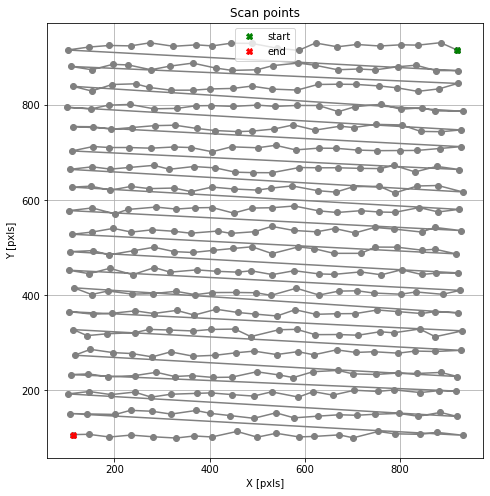

Plotting initial guesses...


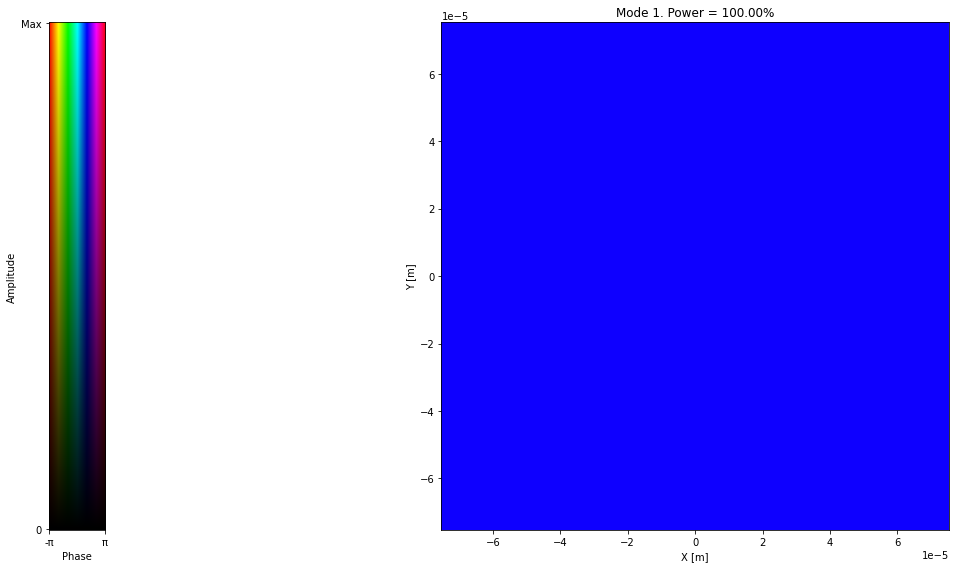

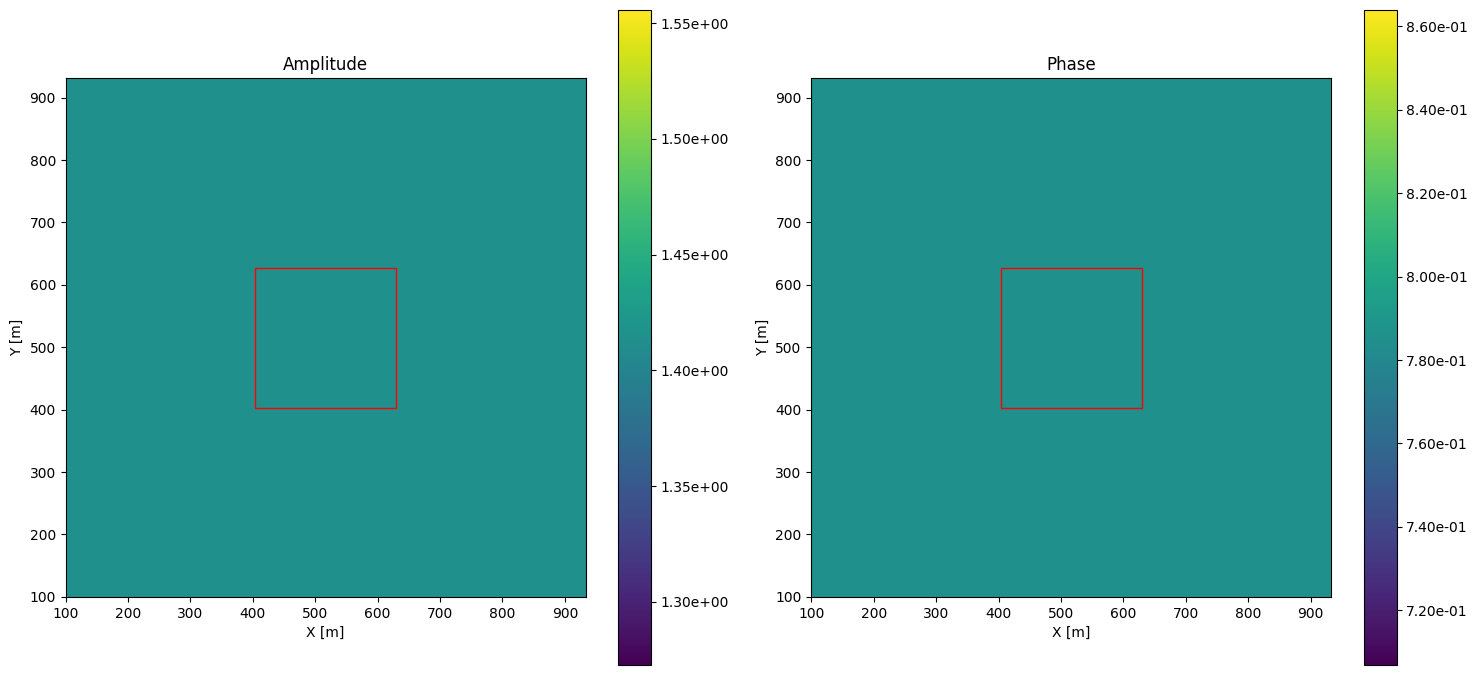

Setting probe support...


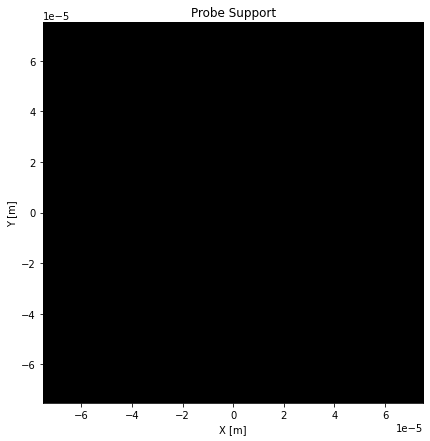

Distance between sample and focus: 0.0mm. Corresponding Fresnel number: 0
Total datapack size: 6.85 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
Calling 10 iterations of RAAR algorithm...
Using CuPy (GPU)
Transfering data to GPU...
Object shape: (1, 3081, 3079)
Probe shape: (1, 2048, 2048)
Diffraction patterns shape: (400, 2048, 2048)
Wavefronts shape: (400, 1, 2048, 2048)
Positions shape: (400, 2)
	Iteration 10/10 	 Errors: R-factor=4.65e-01; MSE=nan; Poisson LLK=nan

Plotting final object and probe...


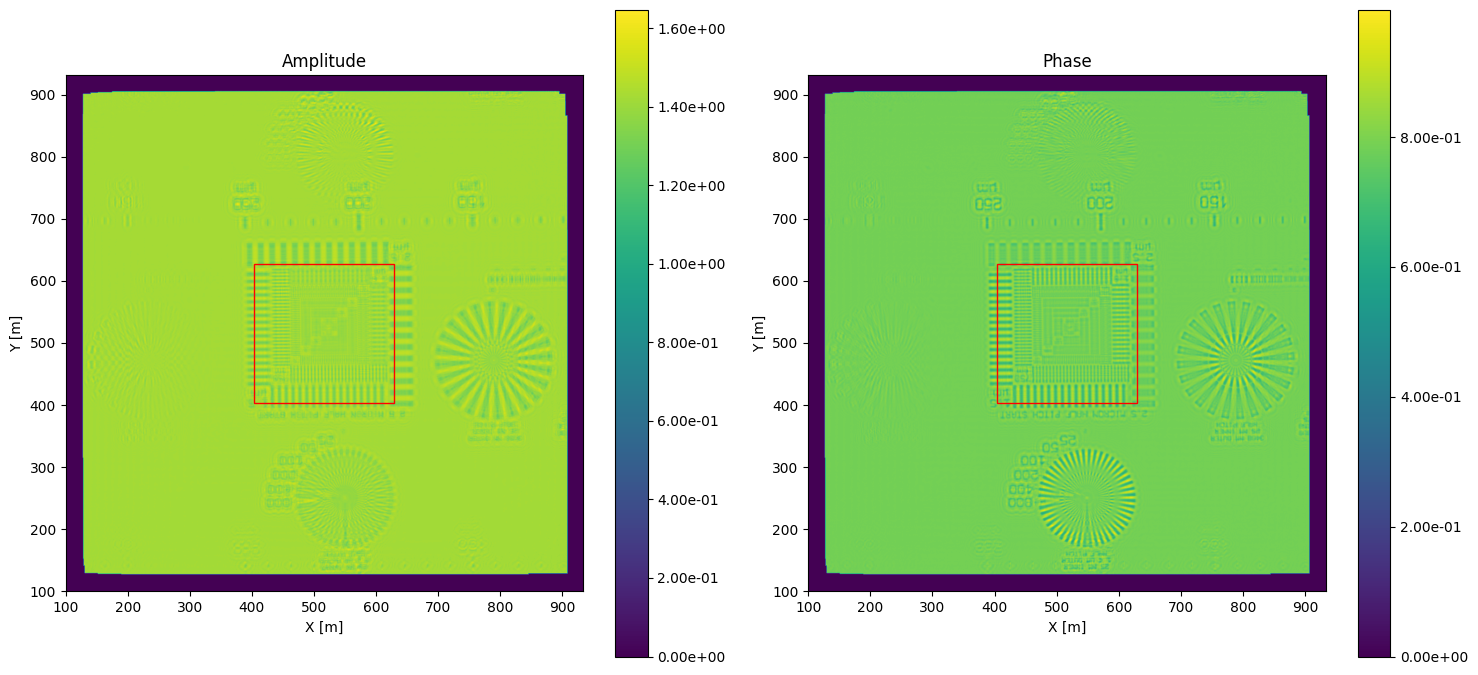

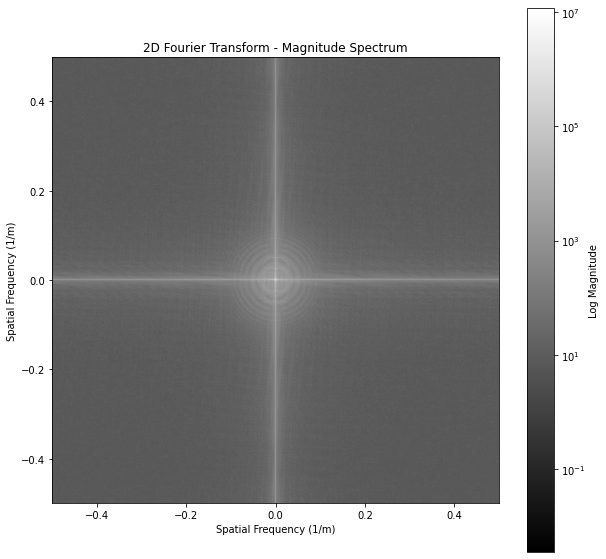

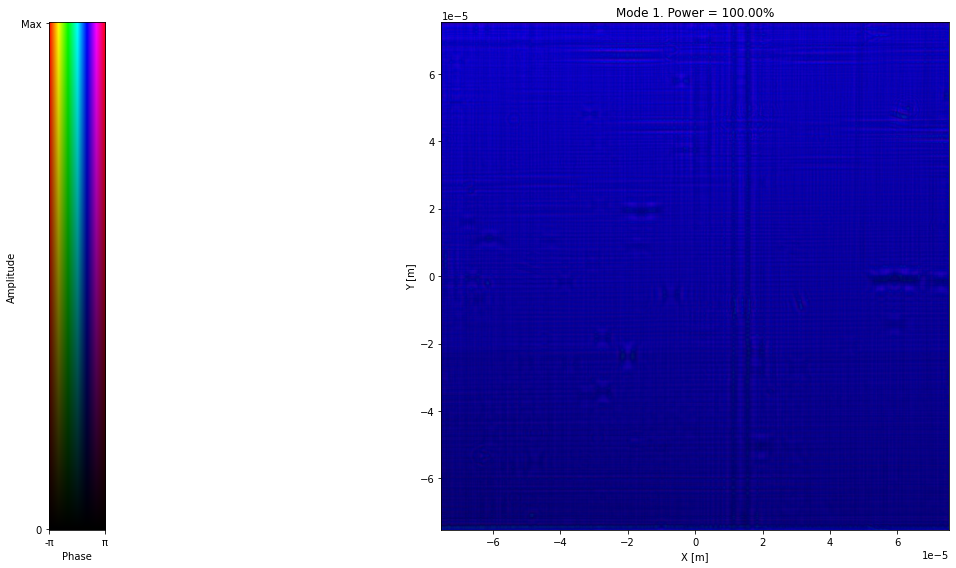

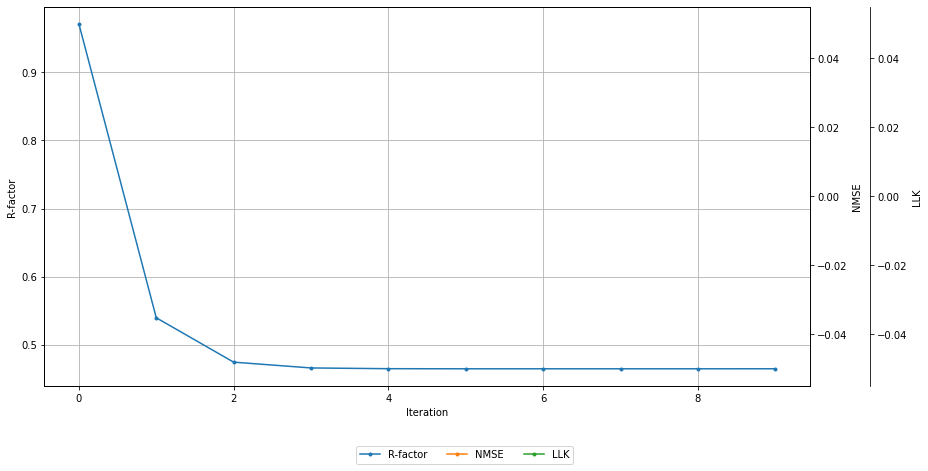

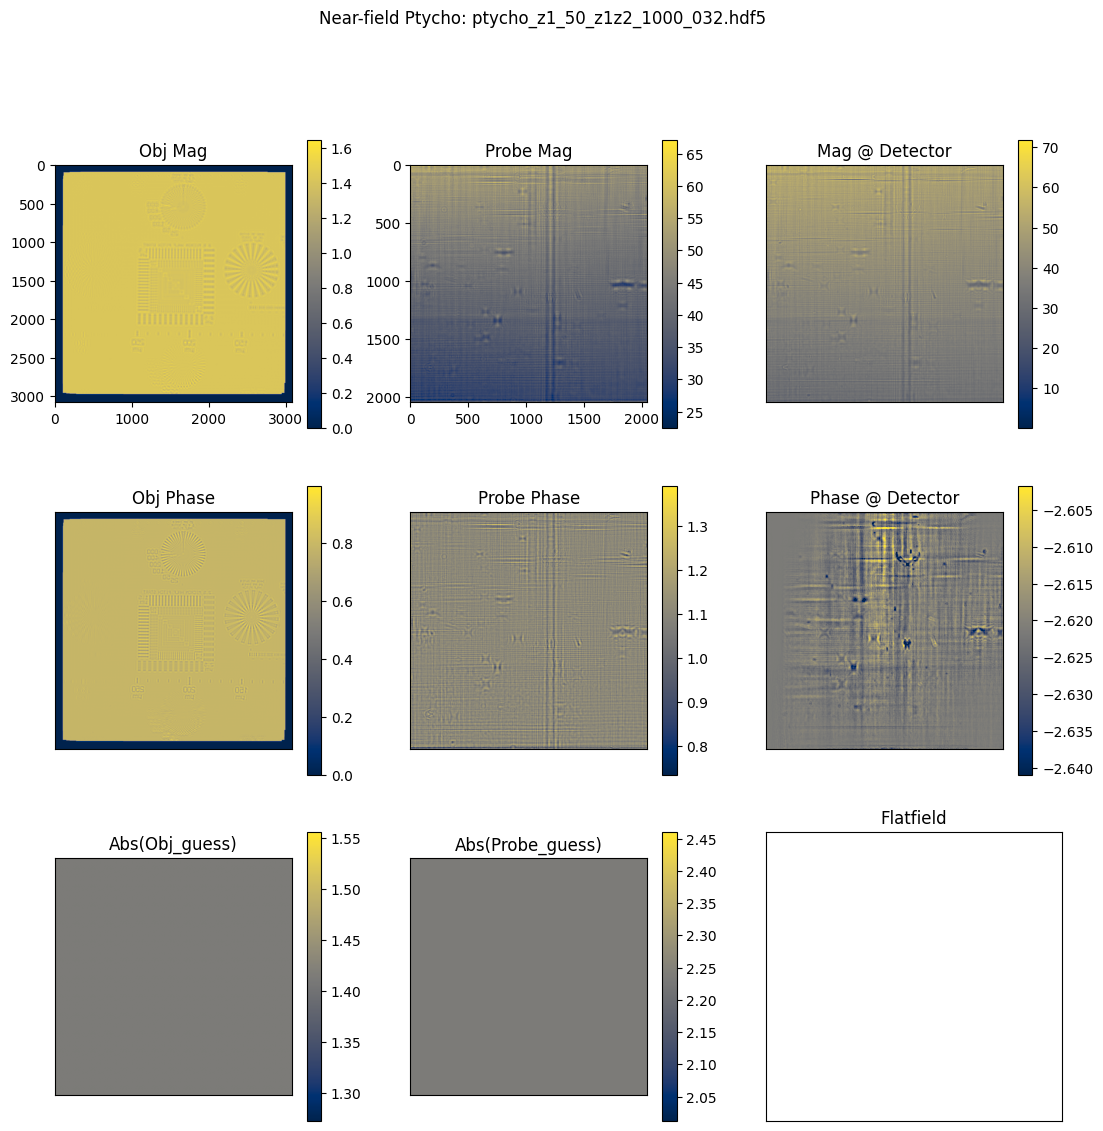

In [39]:
positions_pxls = np.roll(positions_pxls,1,axis=1)
obj, probe, corrected_positions, inputs, error = sscCdi.ptychography.call_ptychography(inputs, DPs, positions_pxls, initial_obj=obj_guess, initial_probe=probe_guess,plot=True)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(probe[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],inputs["source_distance"]) 

RAAR_obj = obj
RAAR_probes = probe

fig, ax = plt.subplots(3,3,figsize=(13,13),dpi=100)

im1=ax[0,0].imshow(np.abs(RAAR_obj))
ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[1,0].imshow(np.angle(RAAR_obj))
ax[1,0].set_title('Obj Phase')
fig.colorbar(im2, ax=ax[1, 0])

im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
ax[0,1].set_title('Probe Mag')
fig.colorbar(im3, ax=ax[0, 1])

im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
ax[1,1].set_title('Probe Phase')
fig.colorbar(im4, ax=ax[1, 1])

im5=ax[0,2].imshow(np.abs(propagated_probe))
ax[0,2].set_title('Mag @ Detector')
fig.colorbar(im5, ax=ax[0, 2])

mean = np.mean(np.angle(propagated_probe))
std=np.std(np.angle(propagated_probe))
im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
ax[1,2].set_title('Phase @ Detector')
fig.colorbar(im6, ax=ax[1,2])

im7 = ax[2,0].imshow(np.abs(obj_guess))
ax[2,0].set_title('Abs(Obj_guess)')
fig.colorbar(im7, ax=ax[2, 0])

im8 = ax[2,1].imshow(np.abs(probe_guess)[0])
ax[2,1].set_title('Abs(Probe_guess)')
fig.colorbar(im8, ax=ax[2, 1])

try:
    im9 = ax[2,2].imshow(flatfield)
    fig.colorbar(im9, ax=ax[2, 2])
except:
    pass
ax[2,2].set_title('Flatfield')


fig.suptitle(f'Near-field Ptycho: {path.split("/")[-1]}')

for i, ax in enumerate(ax.ravel()):
    if i==1 or i==0: continue
    ax.set_xticks([])
    ax.set_yticks([])

-0.005


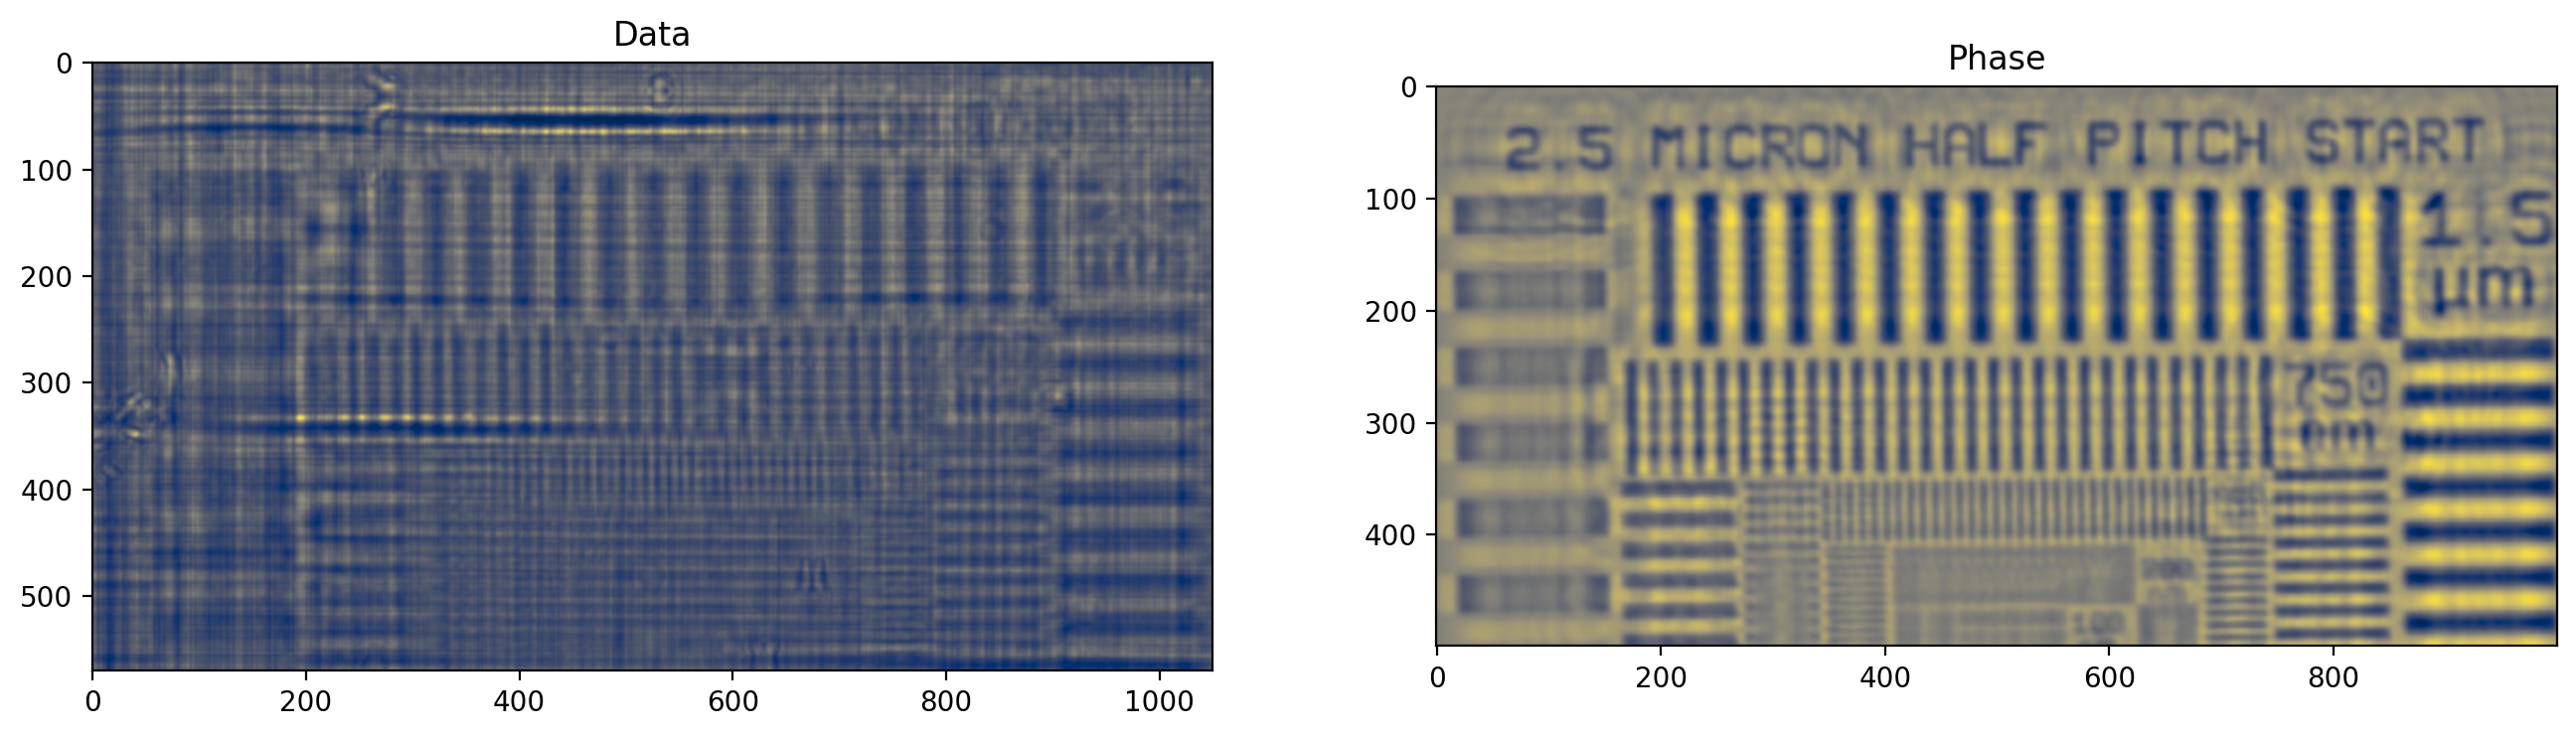

In [87]:
# %matplotlib inline
# distances = np.linspace(-5e-3,-1e-3,10)
# # distances = [0]
# zoom = [1000, 1500, 1000, 2000]

# # RAAR_obj = RAAR_obj[:,::-1]

# for distance in distances:
#     print(distance)
#     propagated_obj = sscCdi.fresnel_propagator_cone_beam(RAAR_obj,inputs["wavelength"],inputs["detector_pixel_size"],distance,inputs["source_distance"]) 


#     fig, ax = plt.subplots(1, 2, figsize=(16, 6.5), dpi=200)

#     # Plot magnitude of propagated_obj
#     # im1 = ax[0].imshow(np.abs(propagated_obj)[zoom[0]:zoom[1], zoom[2]:zoom[3]])
#     im1 = ax[0].imshow(DPs[0][:,::-1][80:650,850:1900])
#     ax[0].set_title('Data')
#     # fig.colorbar(im1, ax=ax[0])

#     # Plot phase of propagated_obj
#     im2 = ax[1].imshow(np.angle(propagated_obj)[zoom[0]:zoom[1], zoom[2]:zoom[3]])
#     ax[1].set_title('Phase')
#     # fig.colorbar(im2, ax=ax[1])

#     plt.show()